# Predicting Crime Rate per County From Economic Factors
#### CPSC 310 Data Mining  
Gonzaga University  
Sebastian Berven and Brett Barinaga

<img src="https://fvmstatic.s3.amazonaws.com/maps/m/US-PPT-02-0005.png" style="float: left;" width="400" height="400">
<img src="https://media.wnyc.org/i/800/0/c/85/1/AP_880772131965_JL9iuj1.jpg" width="400" height="400">


# Forward

The goal of our project is to find effective predictors for determining crime rates using economic information like property values and rent as well as poverty statistics. To do that, we will initially be using the above information in order to predict different crime rates, but also plan on using other techniques like association rule mining in order to determine which factors play a larger role in influencing those rates. In addition, we will also be looking at more advanced ways to visualize the data in order to make our findings more intuitive and clear.

# Datasets

All of the datasets are for the years 2014-2015 and are split by county, which allows for some level of uniformity among the data. They all come in CSV format. The rent dataset has 40,424 rows and 13 relevant attributes: County ID, State Name, County Name, City, Zip Code, Land Area, Water Area, Latitude, Longitude, Mean Rent, Median Rent, STDEV of rent, and sample size. The poverty dataset has 3,198 rows and 10 relevant attributes: the FIPS code, State, County Name, number of people in poverty, percentage of people in poverty, number of people over 17 in poverty, percentage of people over 17 in poverty, number of people ages 0-17 in poverty, percentage of people ages 0-17 in poverty, and median household income. The crime dataset has 3,136 rows and 12 attributes: County name, crime rate, number of murders, rapes, robberies, aggravated assaults, burglaries, larcenies, motor vehicle thefts, arsons, county population, and the FIPS code.

Rent dataset: https://www.kaggle.com/goldenoakresearch/acs-gross-rent-us-statistics/version/3
Poverty dataset: https://www.kaggle.com/rrp170330/variability-in-the-poverty-rate-in-the-us-counties#PovertyEstimates.xls
Crime dataset: https://www.kaggle.com/mikejohnsonjr/united-states-crime-rates-by-county/version/1 

# Preprocessing

Some preprocessing will be necessary, as there is some significant cleaning to be done in order to integrate multiple datasets and deal with conflicting and missing information. In addition, the size of the datasets will require significant computing power in order to obtain useful information. We believe these results will be useful as they will give some insight on the correlation between income, local costs, poverty, and their influence on local crime. This can lead to more effective law enforcement, as well as more efficient philanthropic efforts. These findings would be useful to entities like local and state governments in order to better target welfare programs and help in rent controlling efforts. They would also be useful for charity groups looking to combat poverty and law enforcement groups looking to better focus their limited manpower. 

# Classifier One: KNN
Our first approach for classifying the data is using a k-Nearest Neighbor classifier. This involves an unseen instance in the dataset, computing the the distance of that instance to everyother instance using some sort of distance metric based on its non-class label attributes, in this case we use the Euclidean Distance equation:

$$\sqrt{\sum_{i=1}^{n}(a_i - b_i)^{2}}$$

From there, for an unseen instance, take the top K nearest neighbors and use a voting system (in our case simple majority) to classify that instance. To do this, we used several helper functions:

In [3]:
import utils

def knn_classifier(table, predicted, predictors, test_nums, k = 5):
    '''
    Conducts KNN classifier tests.
    Parameter table: The table to be tested.
    Parameter predicted: Column to be estimated.
    Parameter predictors: List of predictors used to estimate.
    Parameter test_nums: Number of tests to be conducted.
    Parameter k: Amount of nearest neighbors to test.
    '''
    random_table = utils.shuffle_table(table)
    random_table = normalize_table(table, predictors)
    groups = utils.strat_partition(random_table, predicted, test_nums) # Creates equally distributed partitions.
    results = []
    for x in range(test_nums):
        test_set = groups[x]
        train_set = []
        for y in groups[:x] + groups[x+1:]: # Creates test set
            for z in y:
                train_set.append(z)
        results += run_knn_tests(train_set, test_set, k, predicted, predictors)
    return results

def run_knn_tests(training_set, test_set, k, predicted, predictors):
    '''
    Runs KNN tests.
    Parameter training_set: Training data.
    Parameter test_set: Testing data.
    Parameter k: Number of closest neighbors to consider.
    Returns: Test case, guess, actual.
    '''
    closest = []
    for item in test_set:
        test = []
        for row in training_set:
            row.append(euc_distance([item[x] for x in predictors], [row[x] for x in predictors])) # Calculates distance

        training_set.sort(key=operator.itemgetter(-1)) # Sorts on distance.
        candidates = training_set[:k] # Finds k lowest distances.
        choices, count = utils.get_frequencies(candidates, predicted)
        print(candidates)
        test.append(item)
        test.append(choices[count.index(max(count))]) # Finds most common class
        test.append(item[predicted])
        closest.append(test)

        for row in training_set: # Deletes distance row
            del row[-1]

    return closest

among others that can be found in my Github. Then, when running that against our dataset, we get the following result:

In [5]:
import KNN_Functions as knn

data, _ = utils.read_table("combined_data_normalized.csv", True)
class_index = 4
predictors = [2,3,5,9]
results = knn.knn_classifier(data, class_index, predictors, 5, 5) # Runs KNN Tests
accuracy = utils.compute_accuracy(results)
print("The accuracy is", accuracy)
utils.confusion_matrix(results, "Crime Rate?", "KNN Classifier Prediction of Crime Rate")

The accuracy is 0.91
KNN Classifier Prediction of Crime Rate
=============  ======  =====  ========  ===========  ==========  =======  =================
Crime Rate?      High    Low    Medium    Very High    Very Low    Total    Recognition (%)
=============  ======  =====  ========  ===========  ==========  =======  =================
High                0      2         1            0           6        9               0
Low                 1     19         4            0         313      337               5.64
Medium              1      6         0            0          59       66               0
Very High           0      0         0            0           4        4               0
Very Low            0     76        12            0        2334     2422              96.37
=============  ======  =====  ========  ===========  ==========  =======  =================



After testing different values for the amount of neighbors and tests:  
Number of tests equal to 5, 10, 15, 20 and KNN equal to 5, 10, 15 ... 100
    
   
The best accuracy was obtained with tests = 5 and KNN = 5 with 91% accuracy.

# Classifier Two: Naive-Bayes
The next approach for classifying the data is using a naive-bayes classifier. This method of classification relies on Bayes Theorem: 

$$P(H|X) = \frac{P(X|H)P(H)}{P(X)}$$

Where P(H|X) is the probability of event H occuring, given condition X.

This classifier is called "Naive" because it relies on the assumption that the effect of one attribute on the class label is independent from other attributes. Given an unseen instance, the probability of each class label option is calculated based on the values of the other attributes, then the highest probability is used to classify the instance.



For our datasets, we have many continous attributes, and the Bayes equation is used for categorical attributes. We can still use the Naive-Bayes algorithm with our data, with the caveat that we must use an alternate method for computing the probabilites, in this case, using the Gaussian function.
$$g(x, \mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$  

Where the probability of a Value $v_k$ is
$$P(v_k|C) = g(v_k, \mu_C, \sigma_C)$$
And 
- Let μC be the mean of attribute k for instances labeled as C
- Let σC be the standard deviation of attribute k for instances labeled as C
- The probability $P(v_k|C)$ is defined as:


In our implementation of Naive Bayes, we used the following helper functions:

In [ ]:
def naive_bayes_classifier(table, header, k, predicted, predictors, cont_attr = []):
    '''
    Reads a table and returns the specified column.
    Parameter table: The table to be tested.
    Parameter k: Rounds of tests to be conducted.
    Parameter predicted: Column to be estimated.
    Parameter predictors: List of predictors used to estimate.
    Parameter cont_attr: List of which predictors are continuous.
    Returns: Linear regression results, KNN results.
    '''
    random_table = utils.shuffle_table(table)
    
    groups = utils.strat_partition(random_table, predicted, k) # Creates equally distributed partitions.
    results = [] # Initializes necessary variables.
    for x in range(k):
        test_set = groups[x]
        train_set = []
        for y in groups[:x] + groups[x+1:]: # Creates test set
            for z in y:
                train_set.append(z)
            
        bayes_table = create_bayes_table(train_set, header, predicted, predictors, cont_attr)
        results2 = run_bayes_tests(bayes_table, header, test_set, predicted, predictors, cont_attr) # Conducts test
        results += results2
        
    return results

def run_bayes_tests(table, header, test_set, predicted, classifiers, cont_attr):
    solved_set = []
    for item in test_set:
        buffer = []
        buffer.append(item)
        result = calculate_bayes(table, item, header, classifiers, cont_attr) # Finds estimated value.
        buffer.append(result) # Includes guess for the test.
        buffer.append(item[predicted]) # Includes actual value for test.
        solved_set.append(buffer)
    return solved_set

among others that can be found in my Github. Then, when running that against our dataset, we get the following result:

In [8]:
import Naive_Bayes_Functions as bayes

data, header = utils.read_table("combined_data_normalized.csv", True)
class_index = 4
predictors = [2,3,5,9]
results = bayes.naive_bayes_classifier(data, header, 10, class_index, predictors, [2,3,5,9])
accuracy = utils.compute_accuracy(results)
print("The accuracy is", accuracy)
utils.confusion_matrix(results, "Crime Rate?", "Naive Bayes Classifier Prediction of Crime Rate")

The accuracy is 0.9
Naive Bayes Classifier Prediction of Crime Rate
=============  ======  =====  ========  ===========  ==========  =======  =================
Crime Rate?      High    Low    Medium    Very High    Very Low    Total    Recognition (%)
=============  ======  =====  ========  ===========  ==========  =======  =================
High                0      2         0            0           7        9               0
Low                 0     60         2            0         275      337              17.8
Medium              0     15         1            0          50       66               1.52
Very High           0      1         0            0           3        4               0
Very Low            0     57        24            0        2341     2422              96.66
=============  ======  =====  ========  ===========  ==========  =======  =================



# Classifier Three: Decision Tree
The third approach used for classifying an unseen instance, is utilizing a decision tree. Unlike kNN and Naive Bayes which are "instance-at-a-time" classifiers, decisions trees are rule-based. This means that they build a set of general rules from a training set, and then use these rules to classify a new instance. 

Example of a decision tree: <img src="https://raw.githubusercontent.com/GonzagaCPSC310/U5-Decision-Trees/master/figures/iphone_decision_tree_example.png" width="800" height="800">

In our implementation


# Classifier Four: Random Forest 
The fourth approach differs from the previous classifiers, in that a random forest is not a single classifier, but a collection of classifiers, known as 'weak' learners.

# Overall Classifier Performance

# Data Analysis - Plots

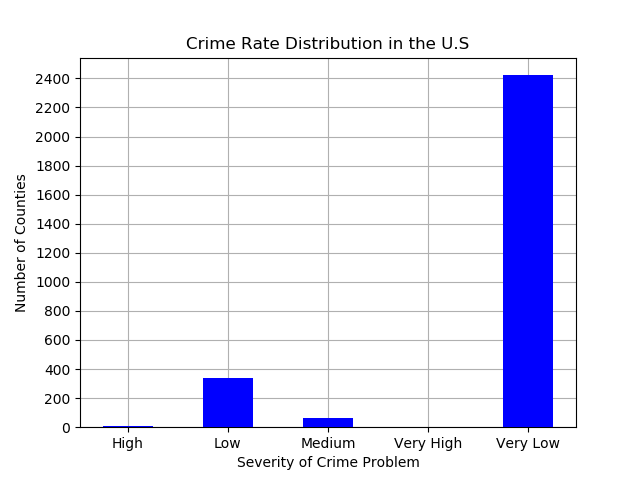

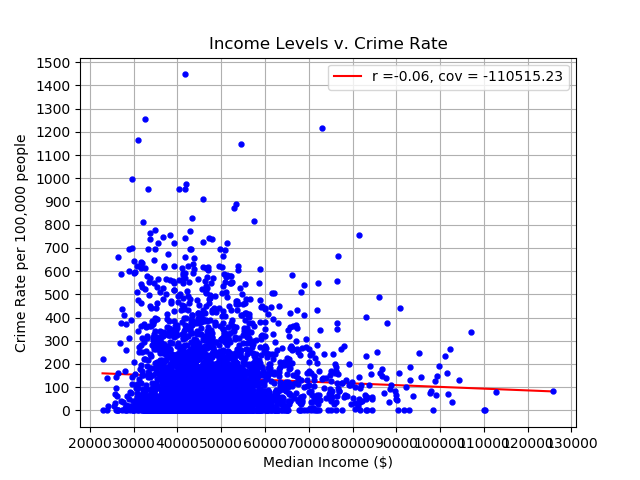

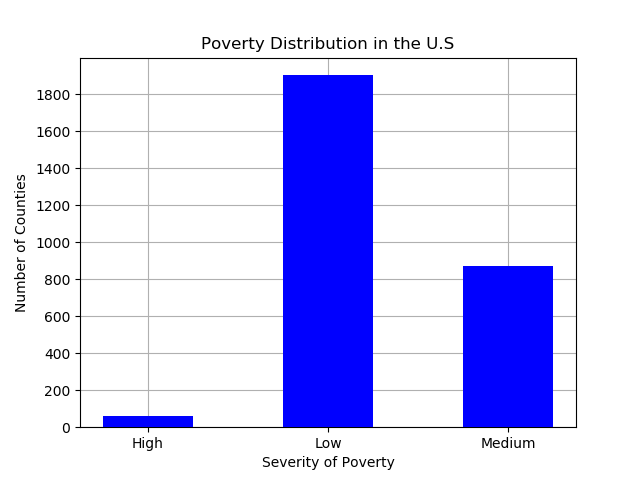

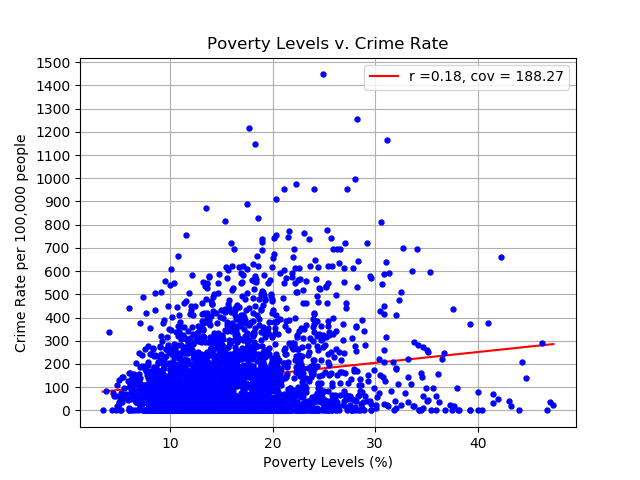

# New Topic: Geomapping Data Visualization

For out new topic, we explored mapping data directly onto to a map, to show relationships between crime data and geographical location. Initially our search for such a technique was unsuccesful, with many implementations requiring datasets with map information built in. Since our datasets did not have this, it took a while trying to figure out how to implement this topic. 

Eventually we found basemap, part of a matplotlib, which doesn't come standard when installing matplotlib. Because of this, coupled with the fact that we weren't using Anaconda, installing basemap was a pain. After hours of searching for whl files, tar files, binaries, and poorly documented readmes, we eventually installed the library and began using it. Not long into the process, we realized that we needed a "shape" (.shp) file to hold information on how to draw the county map. We eventually found such a file from a government website used for data visualization (link at the end of this notebook). With that, we were able to draw a blank map with county lines drawn on. 

To actually place our data onto the map, we decided to use a scatter plot, with each county's longitude and latitude as the x and y axis. We then used varying class labels for our color representation (red for high crime, yellow for medium crime etc). With these componenets, we were able to superimpose our scatterplot over the map, and use the following code to generate a map, using crime as an example:

Crime Data Mapped:
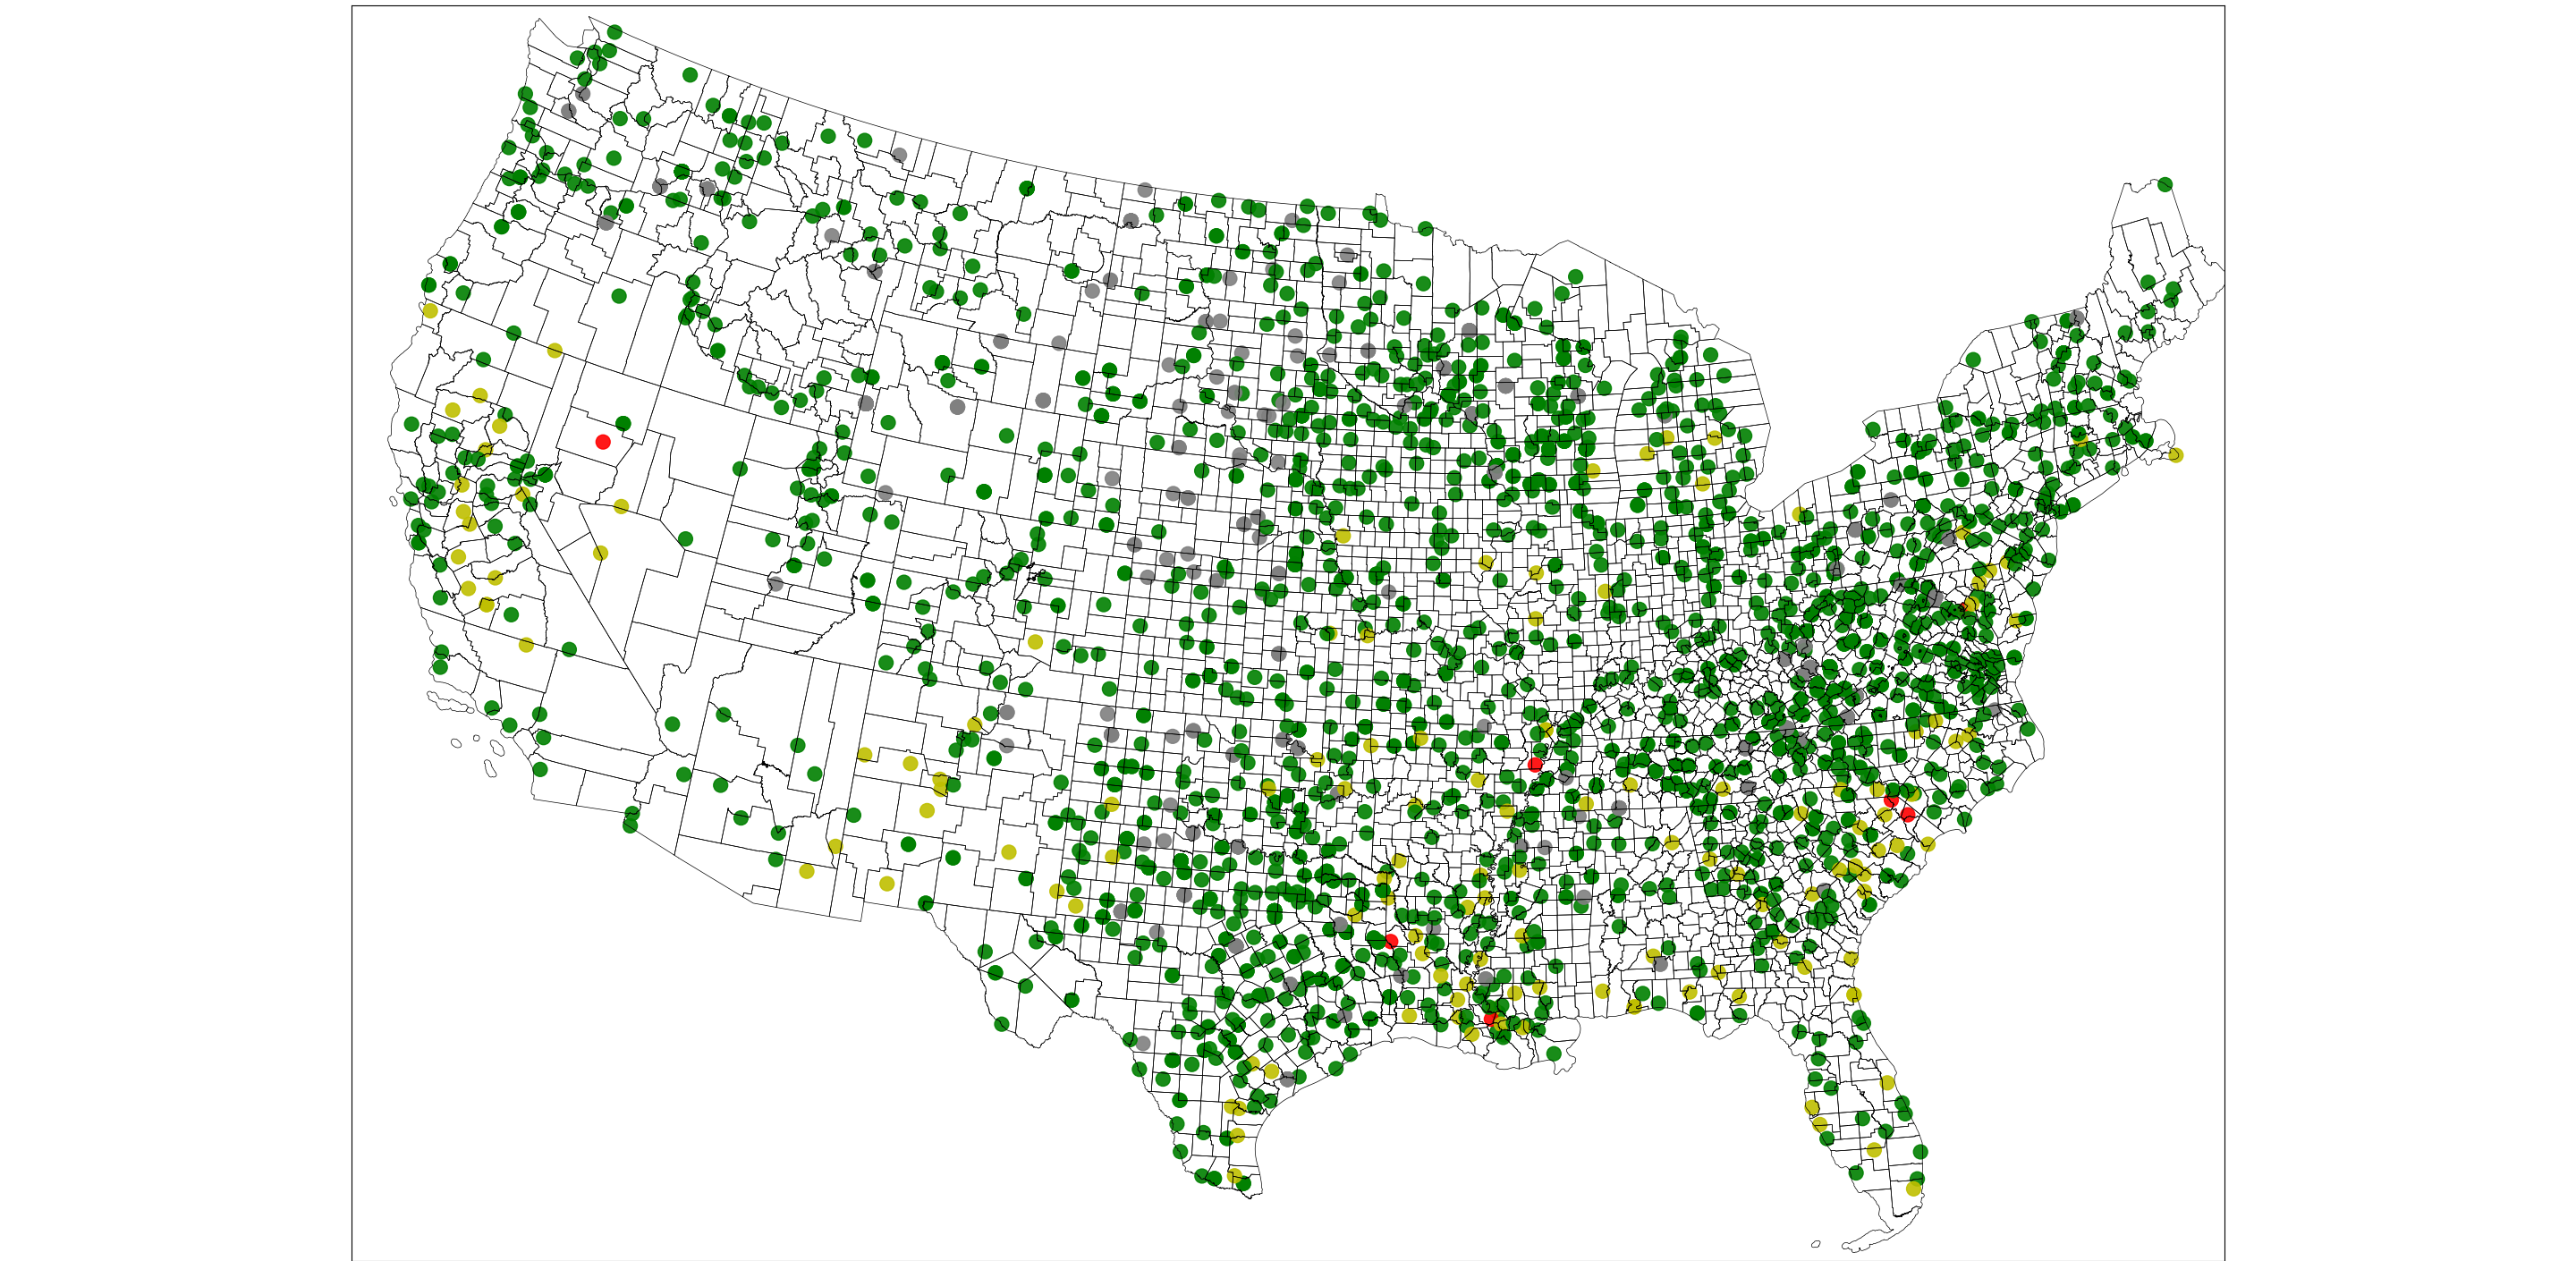

Income Data Mapped:
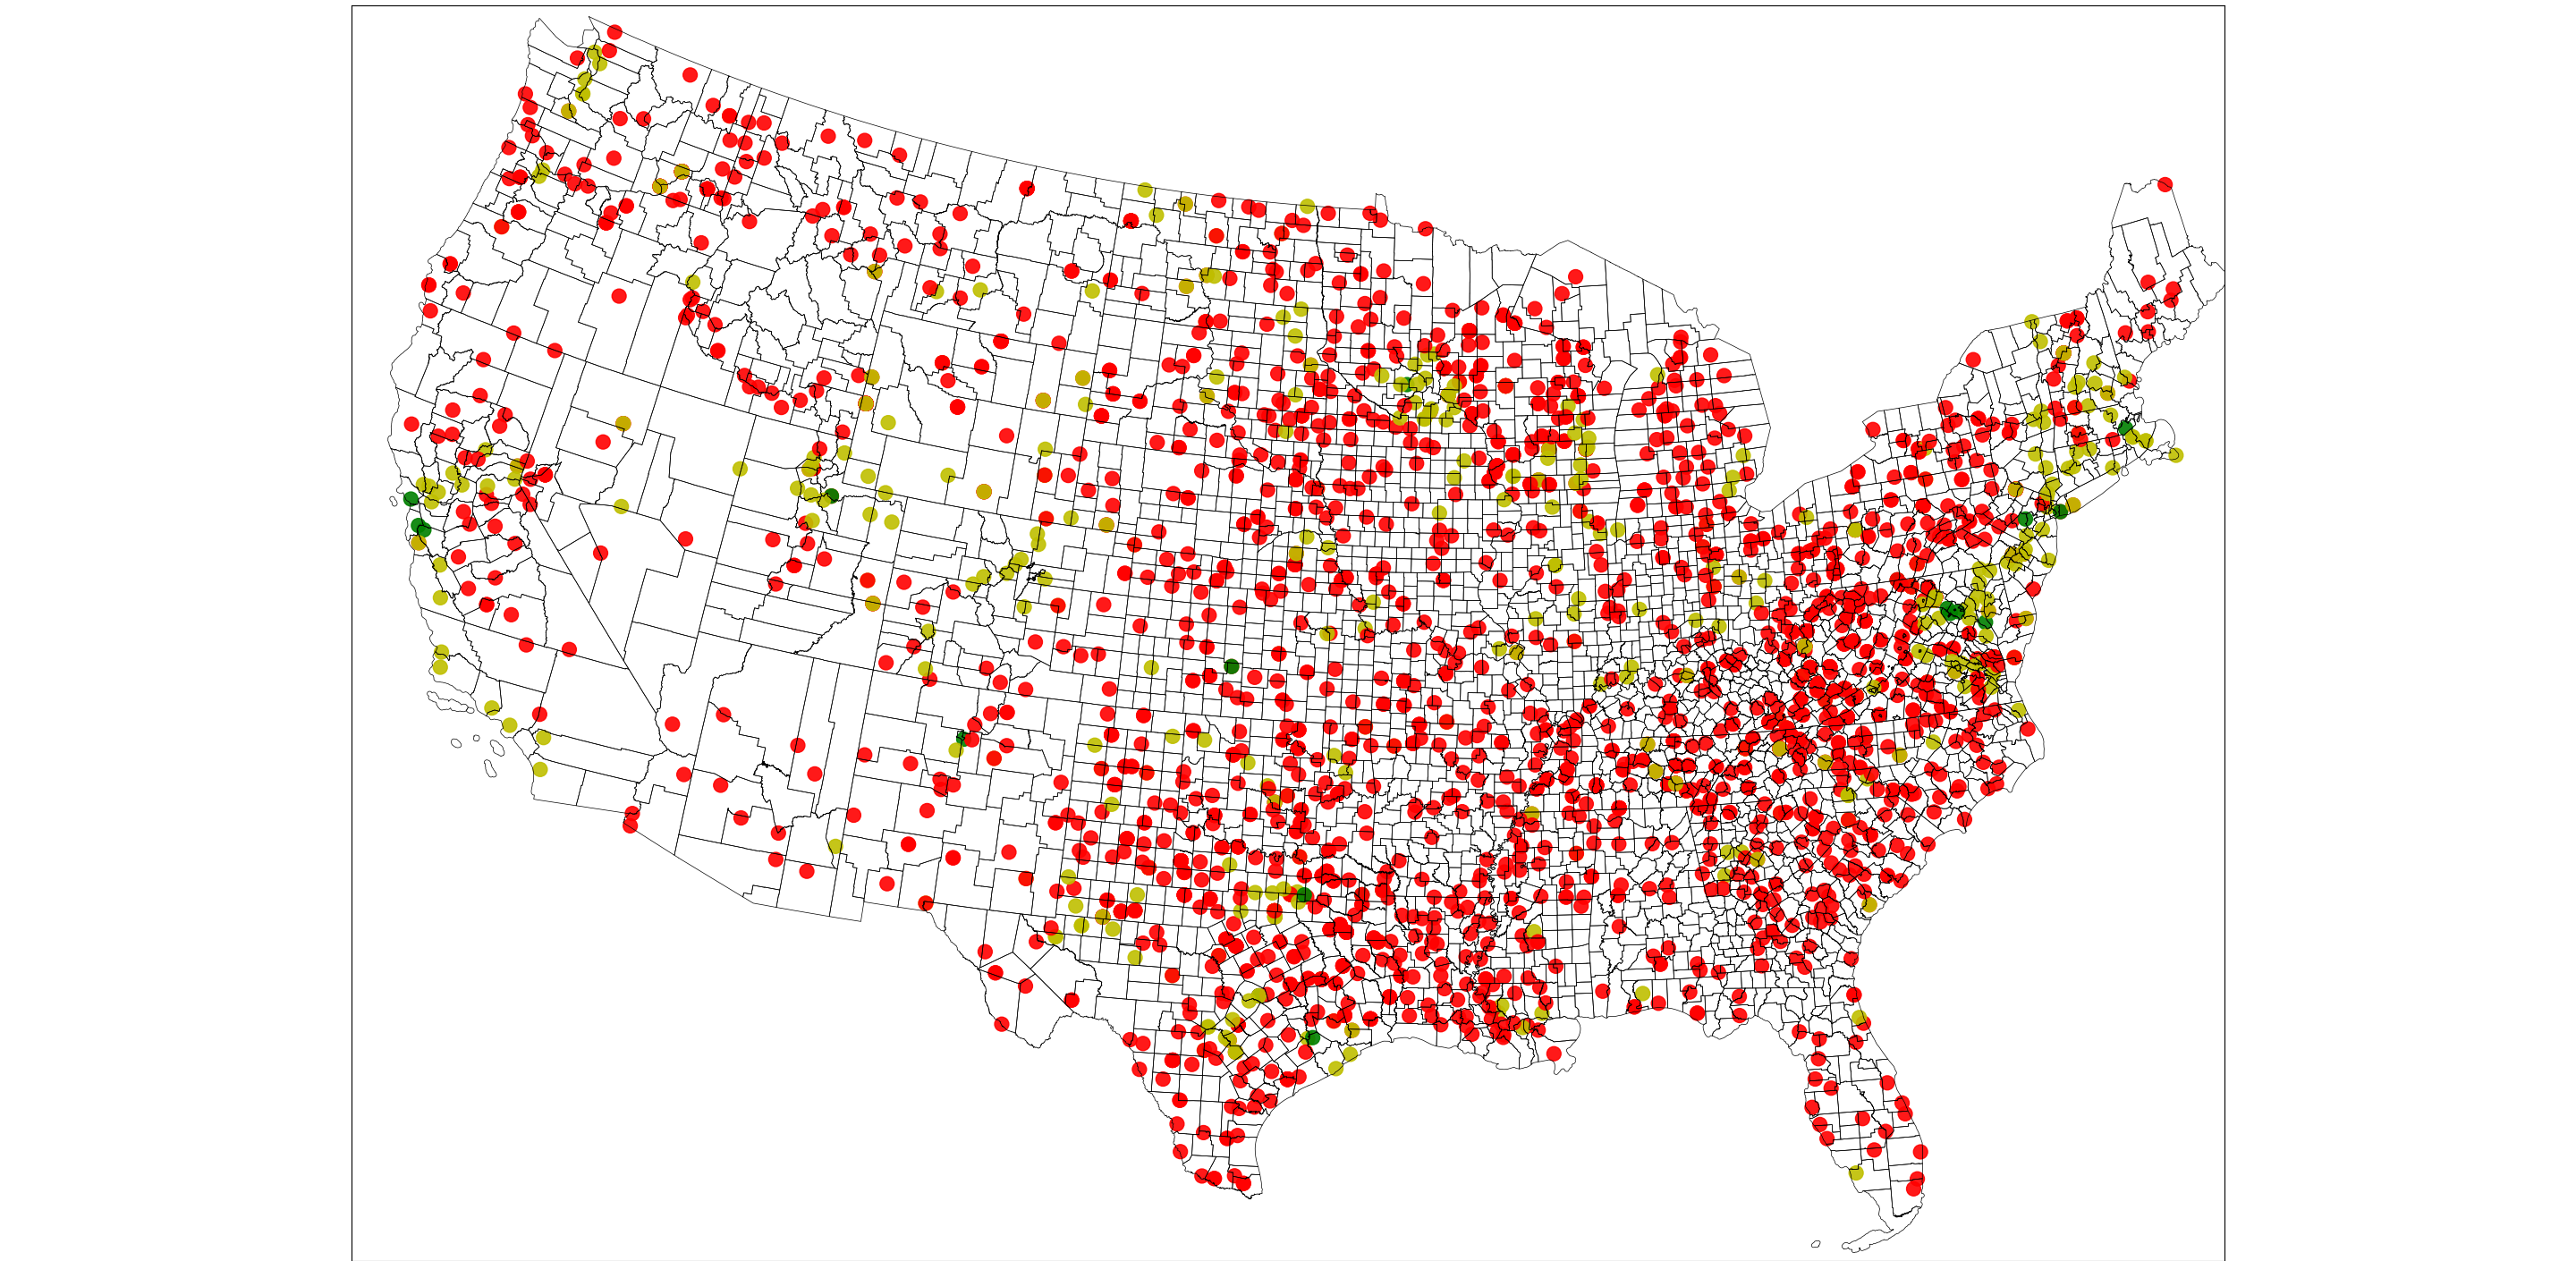

Rent v Income Mapped:
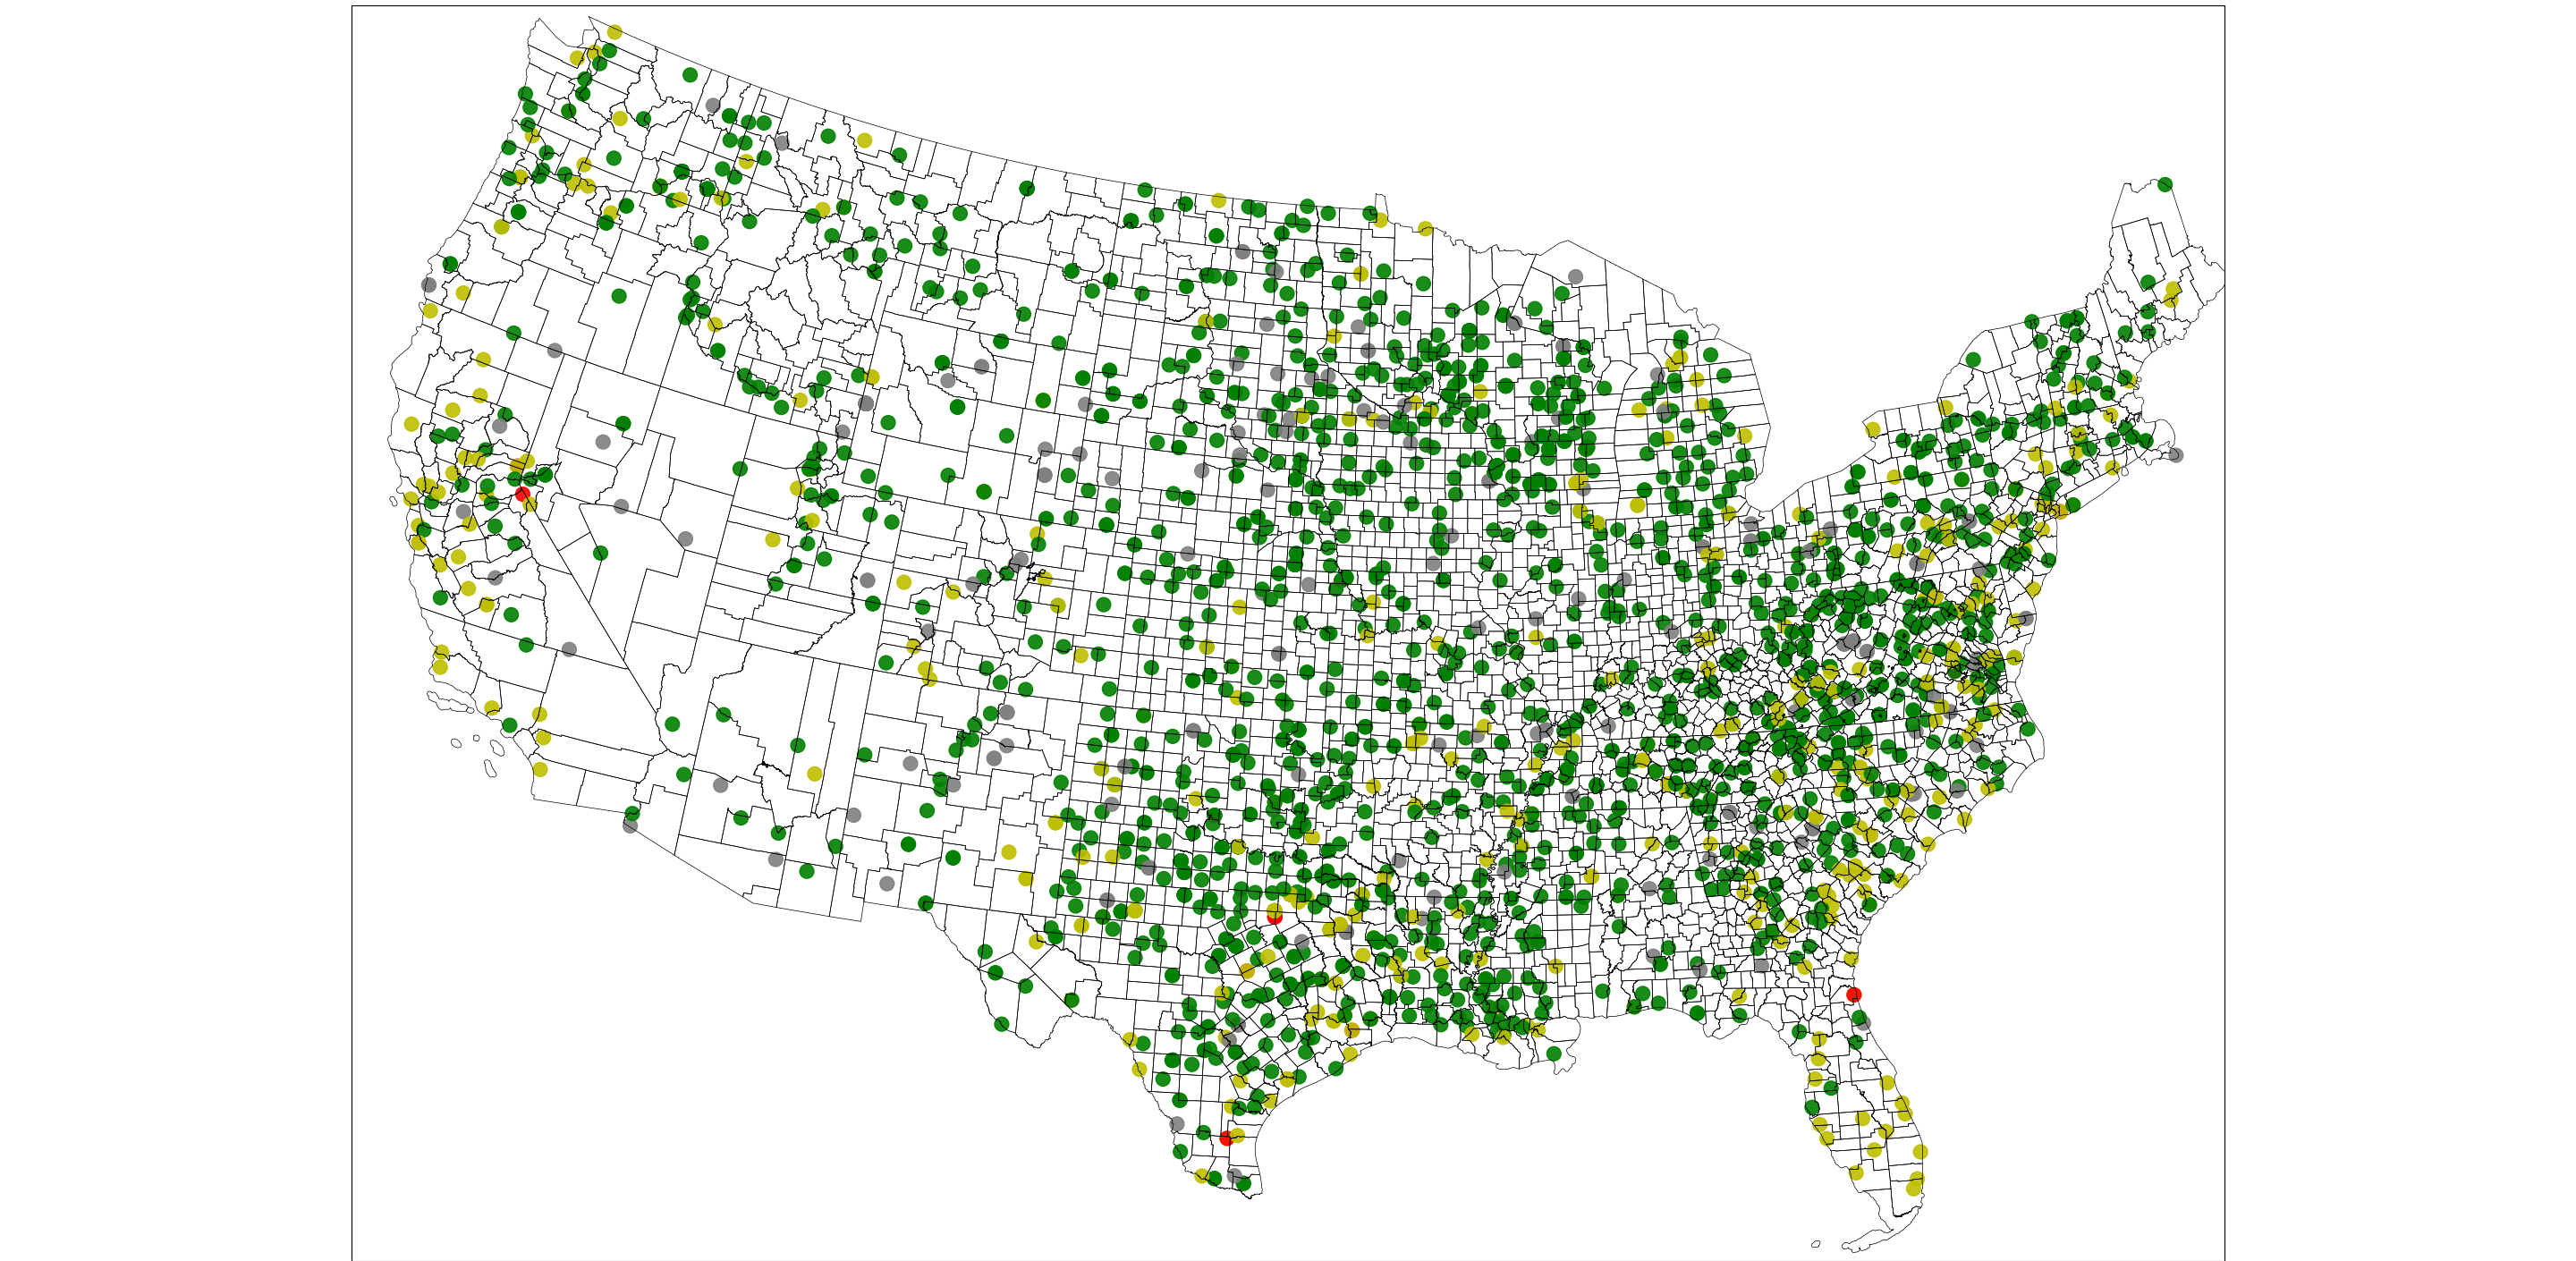

When submitting this part of the project on GitHub, we unfortunately have to zip the folder, since the shapefile used to generate the county map is over 100mb. It will be located in a folder called Geomapping-Data-Visualization.zip
Here is some of our code used to generate the map. Since the required file is kept in a seperate zip folder, we can't include the actual code in this jupyter notebook since it wouldn't be able to run. To test our implementation, unzip the folder and run the "map_plotting.py" script

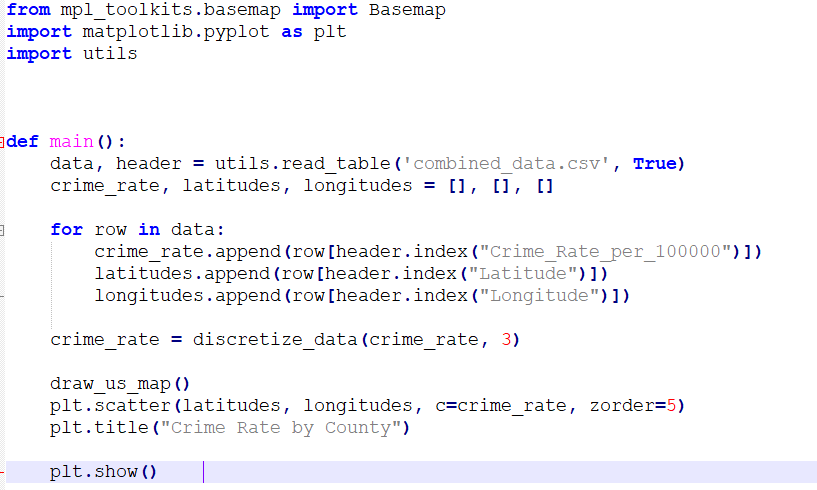

# Conclusion
All in all using three different datasets and joining them together was an interesting challenge but well worth it in the end. Joining all three allowed us to have plenty of attributes to use in our classifiers, and being able to use county longitudes and latitudes. The county name as a common key made joining possible, though we had to through out alot of data. 

Overall our classifiers (KNN, Naive-Bayes, Decision Trees, and Random Forest) all seemed to be fairly accurate. While initially this seems like a good result, when we look at the data we find that since so many counties have low crime, our classifiers could essentially always guess very low for the crime label, and thus be artificially accurate.

To improve this in the future, we could introduce even more than our current ten bins for crime rate. Additionally we could change the classifiers to work with specific crime severities (i.e. homicide, armed robbery are more serious than petty theft). Furthermore, we could try using heterogenous ensemble learners instead of the homegenous random forest ensemble we implemented.

## Additional sources

https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/resource-pages/crime-clock
https://en.wikipedia.org/wiki/County_(United_States)